In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data_handling.model_info import load_model_info
from data_handling import DataLoader, Conversion_Layers

from star_representation import StarRepresentation
from dash_repesentation import DashRepresentation
from reverse_op import PODestarisation

bop_path  = '/tf/notebooks/datasets'
dataset = 'tless'

dataset_path = f'{bop_path}/{dataset}'

print(f'Dataset path:   {dataset_path}')
print(f'GPUs Available: {tf.config.list_physical_devices("GPU")}')

train = ['train_primesense']
test = ['test_primesense']

xyDim = 112

strides = 1

def totuplething(x1, x2, x3, x4, x5, x6, x7):
    return ((x1, x2, x3, x4, x7, x5, x6), x6)

Dataset path:   /tf/notebooks/datasets/tless
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
for oiu in range(1,2):
    # Load model info and data
    print('Object ', oiu)
    model_info = load_model_info(dataset_path, oiu, verbose=1)
    train_data = DataLoader.load_gt_data([f'{dataset_path}/{d}' for d in train ], oiu)
    print(f'Found train data for {len(train_data)} occurencies of object {oiu}, where {len([d for d in train_data if "primesense" in d["root"]])} origined from primesense.')

    # Calculate input values
    inputs, valid_po, isvalid, depth, segmentation = Conversion_Layers.create_Dataset_conversion_layers(xyDim, xyDim, model_info, strides)
    
    # Calculate valid dash and star representations
    valid_dash = DashRepresentation(model_info["symmetries_discrete"][0][:3,-1] / 2. if len(model_info["symmetries_discrete"]) > 0 else 0 )(inputs['roationmatrix'], valid_po)
    valid_po_star = StarRepresentation(model_info)(valid_po)
    po_image = PODestarisation(model_info,amount_of_instances = 1)(valid_po_star, valid_dash, isvalid, inputs['roationmatrix'])

    # Create model
    inference_model = tf.keras.Model(inputs=inputs.values(), outputs=(inputs['rgb'],
                                                                      valid_dash, 
                                                                      valid_po_star,
                                                                      valid_po,
                                                                      isvalid,
                                                                      depth,
                                                                      segmentation,
                                                                      po_image))

    # Infere data
    result = inference_model.predict(DataLoader.Dataset(train_data, xyDim, times=1, group_size=1).batch(1).prefetch(20).map(totuplething))

        

Object  1
model_info for object 1:
diameter : 63.5151
mins : [-17.4958 -17.4958 -30.6   ]
maxs : [17.4958 17.4958 30.6   ]
symmetries_discrete : []
symmetries_continuous : True


100%|██████████| 30/30 [00:00<00:00, 60.07it/s]


Found train data for 1296 occurencies of object 1, where 1296 origined from primesense.
Starring as symmetries_continuous
destarring as symmetries_continuous
Starring as symmetries_continuous
destarring as symmetries_continuous
1296/1296 [==============================] - 7s 5ms/step


2024-05-20 19:43:40.920545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9381996186544144705
2024-05-20 19:43:40.920594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11432464094863957069
2024-05-20 19:43:40.920603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2530098448195499773
2024-05-20 19:43:40.920612: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18372131429825192204
2024-05-20 19:43:40.920618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10561203286883226766
2024-05-20 19:43:40.920625: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4077465832803911432
2024-05-20 19:43:40.920631: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

In [11]:
def transform_array(data, new_min, new_max):
    data_array = np.array(data)
    
    old_min = np.min(data_array)
    old_max = np.max(data_array)
    
    # Avoid division by zero if all elements in data are the same
    if old_min == old_max:
        return np.full(data_array.shape, new_min)
    
    # Apply the linear transformation
    transformed_data = new_min + (data_array - old_min) * (new_max - new_min) / (old_max - old_min)
    
    return transformed_data

# np.save("gt_rgb.npy", result[0])
# np.save("gt_dash.npy", result[1])
# np.save("gt_star.npy", result[2])
# np.save("gt_po.npy", result[3])
# np.save("gt_isvalid.npy", result[4])
# np.save("gt_depth.npy", result[5])
# np.save("gt_segmentation.npy", result[6])
# np.save("gt_po_image.npy", result[7])

In [17]:
rgb = np.array(np.load("/tf/notebooks/results/gt_rgb.npy"), np.uint8)
dash = np.array(transform_array(np.load("/tf/notebooks/results/gt_dash.npy"), 0, 255), np.uint8)
star = np.array(transform_array(np.load("/tf/notebooks/results/gt_star.npy"), 0, 255), np.uint8)
valid_po = np.array(transform_array(np.load("/tf/notebooks/results/gt_po.npy"), 0, 255), np.uint8)
isvalid = np.array(np.load("/tf/notebooks/results/gt_isvalid.npy"))
depth = transform_array(np.load("/tf/notebooks/results/gt_depth.npy"), 0, 1)
segmentation = np.array(np.load("/tf/notebooks/results/gt_segmentation.npy"), np.uint8)
po_image = np.array(transform_array(np.load("/tf/notebooks/results/gt_po_image.npy"),0 , 255), np.uint8)

RGB: (112, 112, 3), uint8, 0, 231
Dash: (112, 112, 3), uint8, 21, 237
Star: (112, 112, 3), uint8, 11, 251
Valid Po: (112, 112, 3), uint8, 11, 251
Is Valid: (112, 112, 1), float32, 0.0, 1.0
Depth: (112, 112), float32, 0.0, 0.9361163973808289
Segmentation: (112, 112), uint8, 0, 255
PO Image: (112, 112, 3), uint8, 11, 251


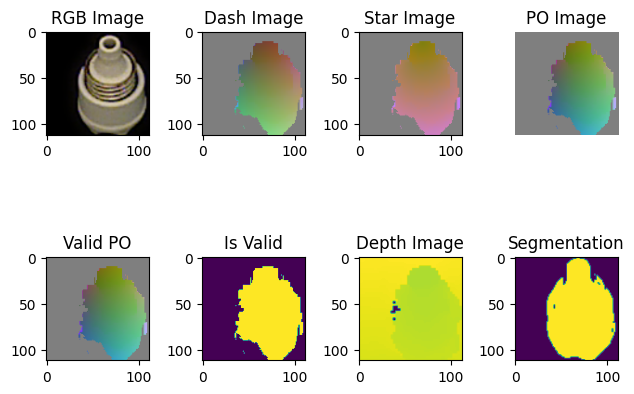

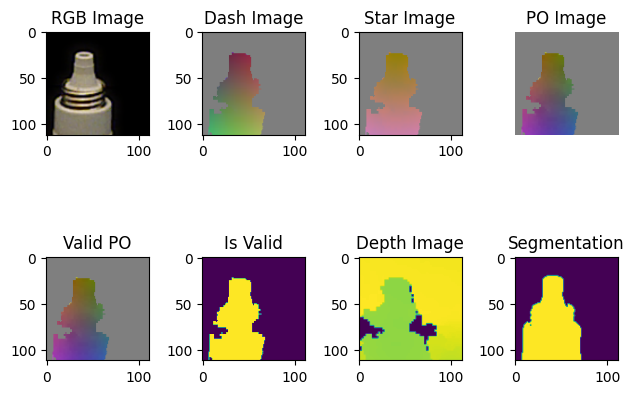

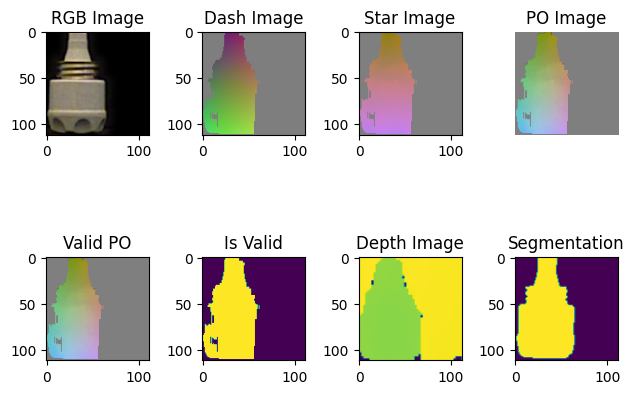

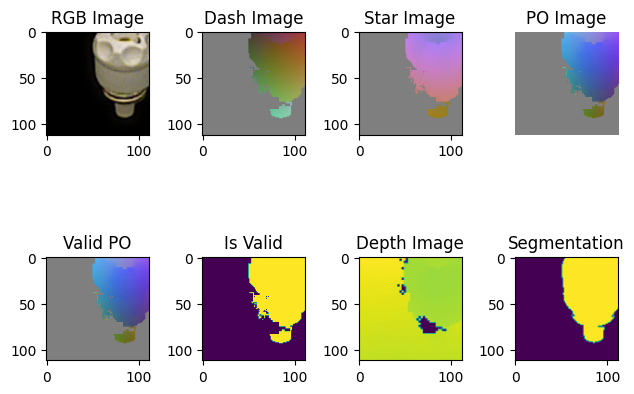

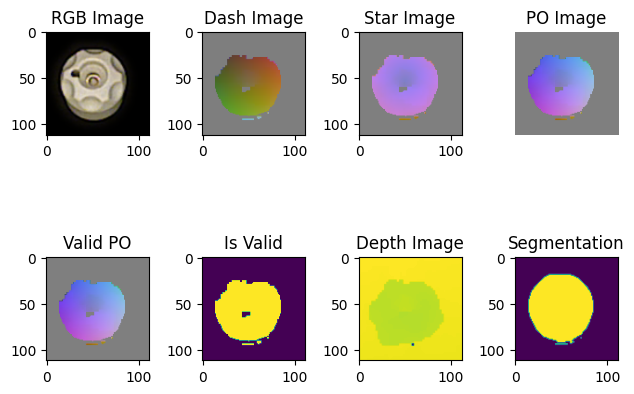

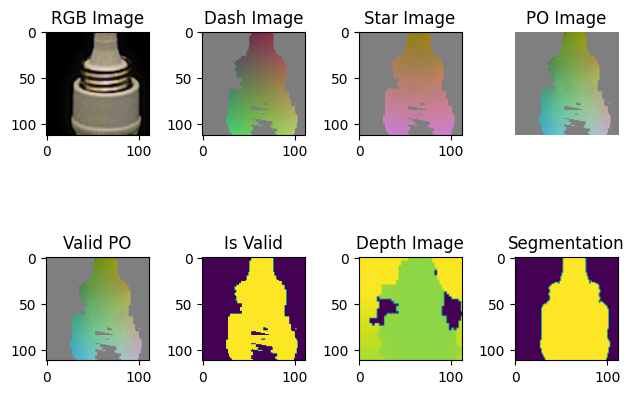

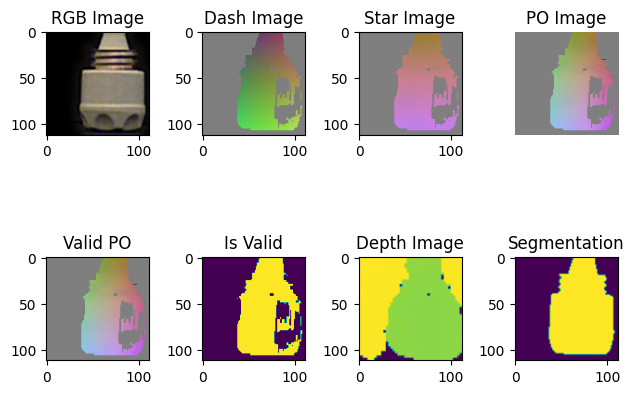

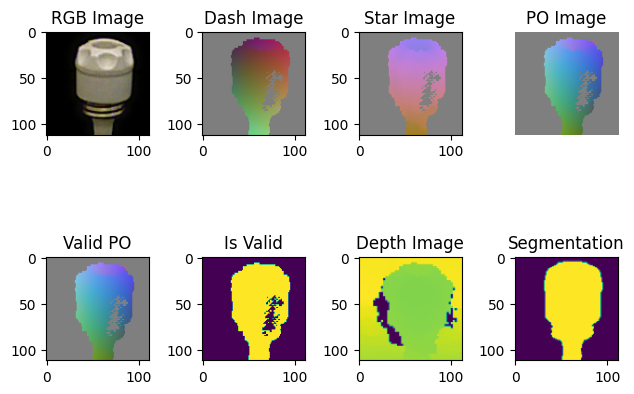

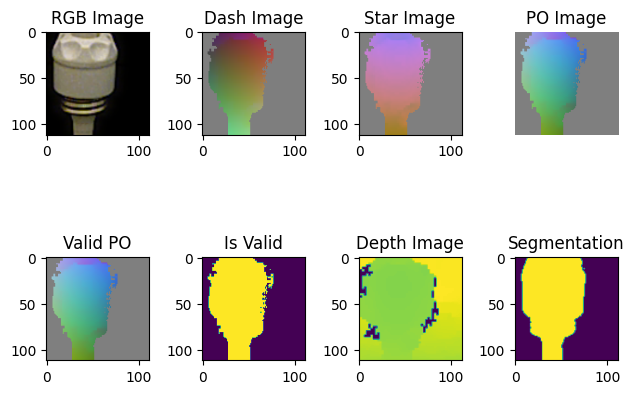

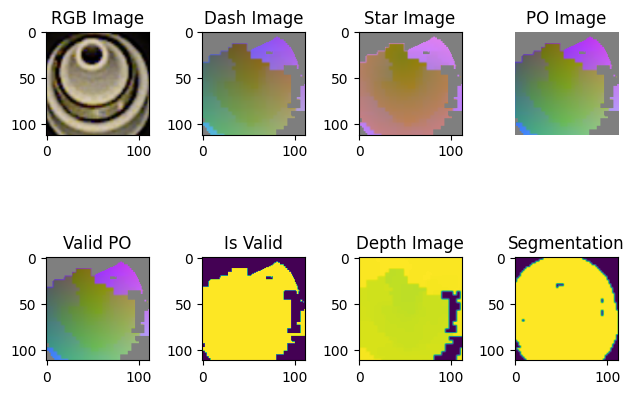

In [18]:
picture = 1000

print(f'RGB: {rgb[picture].shape}, {rgb[picture].dtype}, {rgb[picture].min()}, {rgb[picture].max()}')
print(f'Dash: {dash[picture].shape}, {dash[picture].dtype}, {dash[picture].min()}, {dash[picture].max()}')
print(f'Star: {star[picture].shape}, {star[picture].dtype}, {star[picture].min()}, {star[picture].max()}')
print(f'Valid Po: {valid_po[picture].shape}, {valid_po[picture].dtype}, {valid_po[picture].min()}, {valid_po[picture].max()}')
print(f'Is Valid: {isvalid[picture].shape}, {isvalid[picture].dtype}, {isvalid[picture].min()}, {isvalid[picture].max()}')
print(f'Depth: {depth[picture].shape}, {depth[picture].dtype}, {depth[picture].min()}, {depth[picture].max()}')
print(f'Segmentation: {segmentation[picture].shape}, {segmentation[picture].dtype}, {segmentation[picture].min()}, {segmentation[picture].max()}')
print(f'PO Image: {po_image[picture].shape}, {po_image[picture].dtype}, {po_image[picture].min()}, {po_image[picture].max()}')

pic_numbers = np.random.randint(0, 1296, 10)

for picture in pic_numbers:   
    f, axarr = plt.subplots(2, 4)
    # Display images and set titles
    axarr[0, 0].imshow(rgb[picture])
    axarr[0, 0].set_title('RGB Image')
    axarr[0, 1].imshow(dash[picture])
    axarr[0, 1].set_title('Dash Image')
    axarr[0, 2].imshow(star[picture])
    axarr[0, 2].set_title('Star Image')
    axarr[0, 3].imshow(po_image[picture])
    axarr[0, 3].set_title('PO Image')
    axarr[0, 3].axis('off')  # Turn off axis for the empty subplot
    axarr[1, 0].imshow(valid_po[picture])
    axarr[1, 0].set_title('Valid PO')
    axarr[1, 1].imshow(isvalid[picture])
    axarr[1, 1].set_title('Is Valid')
    axarr[1, 2].imshow(depth[picture])
    axarr[1, 2].set_title('Depth Image')
    axarr[1, 3].imshow(segmentation[picture])
    axarr[1, 3].set_title('Segmentation')
    # Adjust layout to make space for titles
    plt.tight_layout()
    # Show the plot
    plt.show()

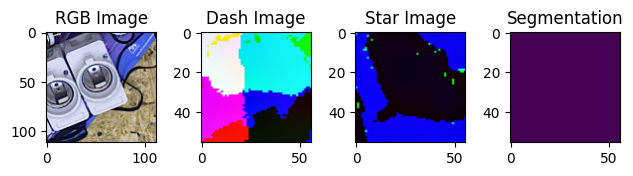

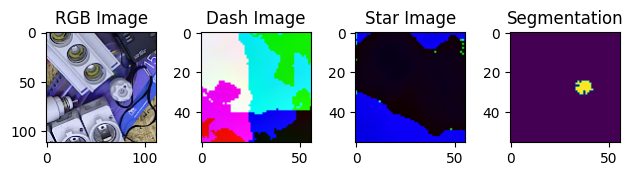

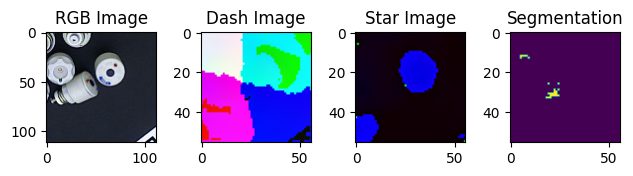

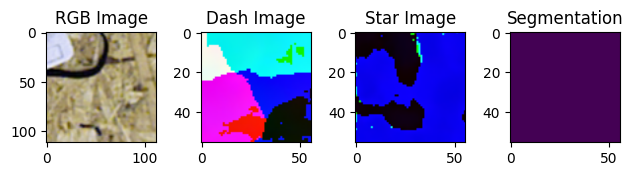

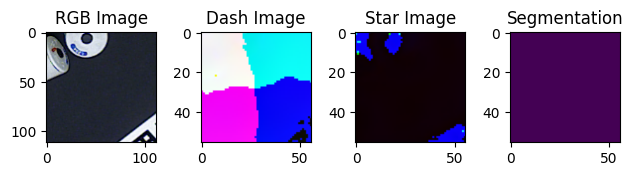

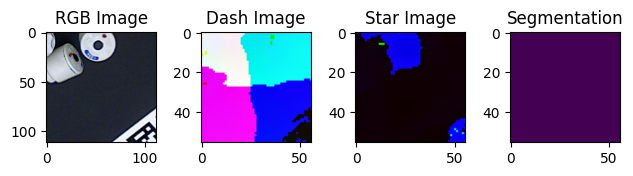

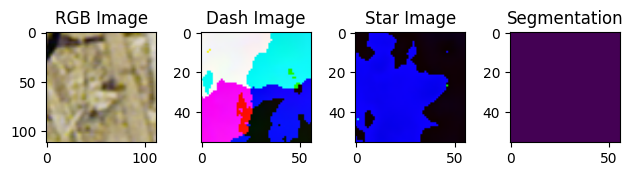

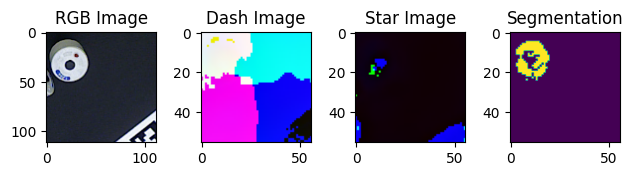

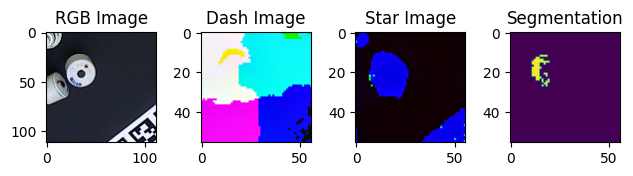

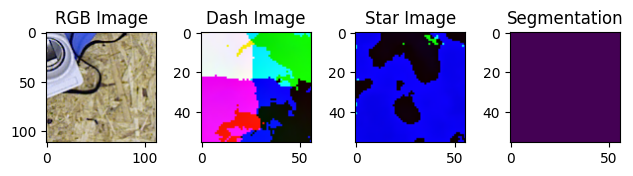

In [5]:
rgb_npy = np.load('/tf/notebooks/results/rgb_input.npy')
star_npy = np.load('/tf/notebooks/results/star.npy')
dash_npy = np.load('/tf/notebooks/results/dash.npy')
segmentation_npy = np.load('/tf/notebooks/results/seg.npy')


pic_numbers = np.random.randint(0, 1000, 10)

for picture in pic_numbers:
    rgb_image=np.array(rgb_npy[picture], np.uint8)
    star_image=np.array(star_npy[picture], np.uint8)
    dash_image=np.array(dash_npy[picture], np.uint8)
    segmentation_image=np.array(segmentation_npy[picture], np.uint8)

    f, axarr = plt.subplots(1, 4)
    # Display images and set titles
    axarr[0].imshow(rgb_image)
    axarr[0].set_title('RGB Image')
    axarr[1].imshow(dash_image)
    axarr[1].set_title('Dash Image')
    axarr[2].imshow(star_image)
    axarr[2].set_title('Star Image')
    axarr[3].imshow(segmentation_image)
    axarr[3].set_title('Segmentation')
    # Adjust layout to make space for titles
    plt.tight_layout()
    # Show the plot
    plt.show()
    



